In [12]:
using Plots
using Random
rng = MersenneTwister(1234);

# Langevin SDE

Let's simulate the Langevin process under a confining potential $U(x) = \|x\|^2/2$ in two dimensions:
\begin{align*}
dV_t &= -X_t dt -\gamma V_t dt + \gamma \sqrt{2D} dW_t, \qquad & V_0 &= (0,0),\\
dX_t &= V_t dt, \qquad & X_0 &= (5,0).
\end{align*}

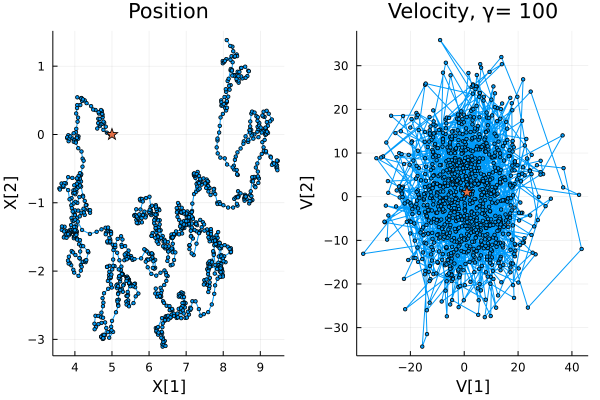

In [15]:
function Langevin_trajectory(Tf, Δt, γ, D)
    N = floor(Int, Tf/Δt);  # number of steps required
    
    dW = sqrt(Δt)*randn(rng,N,2);   # Brownian increments

    # Approximate with Euler-Maruyama:
    X = zeros(N+1,2);               # vectors to store the trajectory
    V = zeros(N+1,2); 

    X[1,:] = [5; 0];                # initialise
    V[1,:] = [1; 1];

    for i = 2:N+1
        V[i,:] = V[i-1,:] .-(X[i-1,:] .+ γ*V[i-1,:])*Δt .+ γ*sqrt(2*D)*dW[i-1,:]; 
        X[i,:] = X[i-1,:] .+ V[i-1,:] * Δt;
    end

    plt1 = plot(X[:,1], X[:,2],
        xlabel="X[1]",
        ylabel="X[2]",
        title = "Position",
        markershape = :circle,
        markersize = 2
        # , aspect_ratio = :equal
    );

    # plot the initial condition
    plot!(plt1, [X[1,1]], [X[1,2]],
            markershape = :star5,
            markersize = 6
    );

    plt2 = plot(V[:,1], V[:,2],
    xlabel="V[1]",
    ylabel="V[2]",
    title = "Velocity, γ= $γ",
    markershape = :circle,
    markersize = 2
    );

    # plot the initial condition
    plot!(plt2, [V[1,1]], [V[1,2]],
            markershape = :star5,
            markersize = 6
    );

    plt = plot(plt1, plt2, layout = (1,2), legend = false)

    return plt
end

## Problem parameters
γ = 100; # drag coefficient       ## change to γ = 10, 100 for more damping
D = 1; # diffusion
Tf = 5; N = 2^10; Δt = Tf/N;

plt = Langevin_trajectory(Tf, Δt, γ, D);
display(plt)

# Overdamped Langevin SDE

We can compare with the overdamped trajectory, 
$$
dX_t = - \frac{U'(X_t)}{\gamma} dt + \sqrt{2D} dW_t, \qquad X_0 = (5,0)
$$

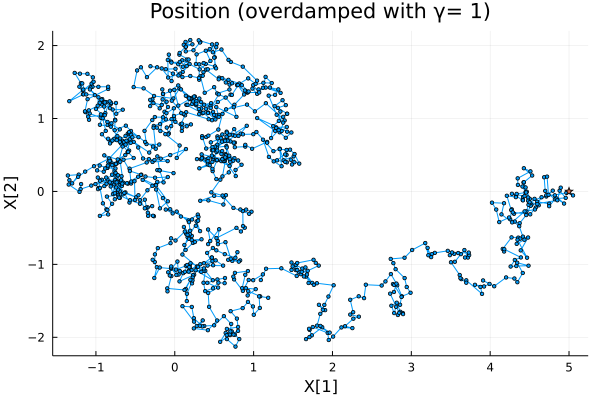

In [17]:
function ODLangevin_trajectory(Tf, Δt, γ, D)
    N = floor(Int, Tf/Δt);  # number of steps required
    dW = sqrt(Δt)*randn(rng,N,2);   # Brownian increments

    X = zeros(N+1,2);               # vectors to store the trajectory
    X[1,:] = [5; 0];                # initialise

    for i = 2:N+1
        X[i,:] = X[i-1,:] .- (1/γ)*X[i-1,:]*Δt .+ sqrt(2*D)*dW[i-1,:];
    end

    plt = plot(X[:,1], X[:,2],
        xlabel="X[1]",
        ylabel="X[2]",
        title = "Position (overdamped with γ= $γ)",
        label = "",
        markershape = :circle,
        markersize = 2)

    # plot the initial condition
    plot!([X[1,1]], [X[1,2]],
    markershape = :star5,
    label = "")

    return plt
end

## Problem parameters
γ = 1; # drag coefficient       
D = 1; # diffusion
Tf = 5; N = 2^10; Δt = Tf/N;

plt = ODLangevin_trajectory(Tf, Δt, γ, D);
display(plt)


# Distributions

Let's compare the distributions of the Langevin and overdamped Langevin at time Tf. 

For this, write down functions that do M trajectories and only store the final time

In [18]:
# This function integrates the one-dimensional Langevin SDE until time Tf
# using a timestep Δt, starting at X_0 = 1 and V_0 = 1, and U(x) = x^2/2
# dV_t = -U'(X_t)*dt -γ*V_t*Δt + γ*sqrt(2*D)*dW_t, dX_t = V_t*Δt
# D: diffusion coefficient, γ = drag coefficient
# M: number of samples (from Tf forward using process is ergodic)
function Langevin_average(Tf, Δt, γ, D; M=1)
    N = floor(Int, Tf/Δt);  # number of steps required
    X = zeros(M); V = zeros(M);
    X[1] = 5.0;         # initial position
    V[1] = 1.0;         # initial velocity
    for i = 1:N
        Vtemp = V[1] -(X[1] .+ γ*V[1])*Δt .+ γ*sqrt(2*D*Δt)*randn(rng); 
        X[1] = X[1] .+ V[1] * Δt;
        V[1] = Vtemp;
    end
    # start saving all the points from now on
    for i = 2:M
        Vtemp = V[i-1] -(X[i-1] .+ γ*V[i-1])*Δt .+ γ*sqrt(2*D*Δt)*randn(rng); 
        X[i] = X[i-1] + V[i-1] * Δt;
        V[i] = Vtemp;
    end

    return [X,V]
end

Langevin_average (generic function with 1 method)

In [19]:
# This function integrates the one-dimensional overdamped Langevin SDE until time Tf
# using a timestep Δt, starting at X_0 = 5, and U(x) = x^2/2
# dX_t = -U'(X_t)/γ*dt + sqrt(2*D)*dW_t
# D: diffusion coefficient, γ = drag coefficient
# M: number of samples (from Tf onwards using ergodicity)
function ODLangevin_average(Tf, Δt, γ, D; M=1)
    N = floor(Int, Tf/Δt);  # number of steps required
    X = zeros(M);
    X[1] = 5.0;    # position vector
    for i = 1:N
        X[1] = X[1] - X[1]*Δt/γ .+ sqrt(2*D*Δt)*randn(rng); 
    end
    
    # start saving all the points from now on
    for i = 2:M
        X[i] = X[i-1] - X[i-1]*Δt/γ .+ sqrt(2*D*Δt)*randn(rng); 
    end
    
    return X
end

ODLangevin_average (generic function with 1 method)

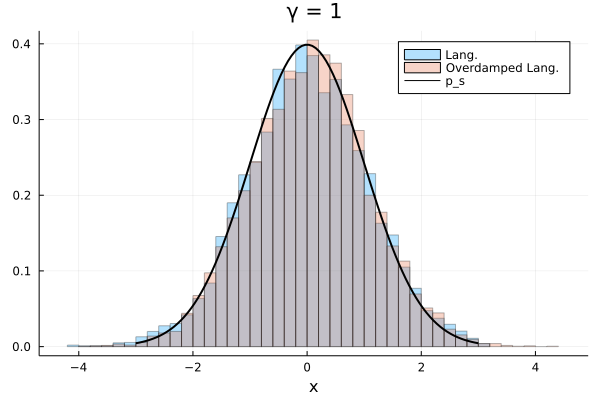

In [20]:
function compare_averages(Tf, Δt, γ, D; M = 1)
        X, V = Langevin_average(Tf, Δt, γ, D; M = M);
        Xod = ODLangevin_average(Tf, Δt, γ, D; M = M);

        # plot the histograms
        plt = plot(X,
                # bins = -5:0.2:5,
                normalize=true,
                label="Lang.",
                xlabel="x",
                alpha = 0.3,
                seriestype = :histogram,
                title = "γ = $γ"
        )

        plot!(Xod,
                # bins = -5:0.2:5,
                normalize=true,
                label="Overdamped Lang.",
                xlabel="x",
                alpha = 0.3,
                seriestype = :histogram
        )

        # also include the stationary density
        x = range(-3, stop=3, length=100);
        α = 1/γ
        p_s(x) = sqrt(α/(2*pi*D)) * exp.(-α * x.^2/(2*D)); # stationary measure for the OU process
        plot!(x, p_s(x), 
                label="p_s",
                linewidth=2,
                linecolor=:black
        )

        return plt
end

Tf = 10; Δt=0.1; D = 1;
M = 10000; # number of samples
γ = 1; # compare results as γ is varied
plt = compare_averages(Tf, Δt, γ, D; M = M)



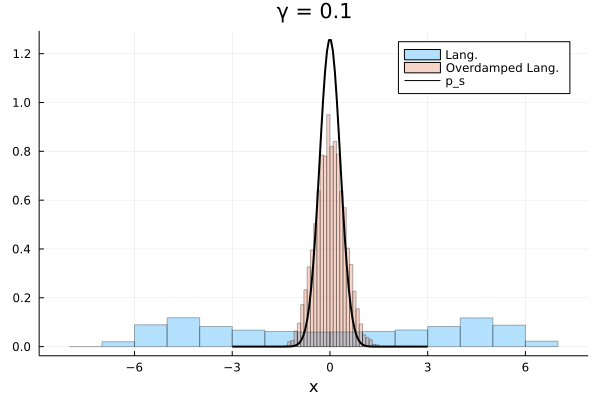

In [21]:
Tf = 1; Δt=0.1; D = 1;
M = 10000; # number of samples
γ = 0.1; # compare results as γ is varied
plt = compare_averages(Tf, Δt, γ, D; M = M)

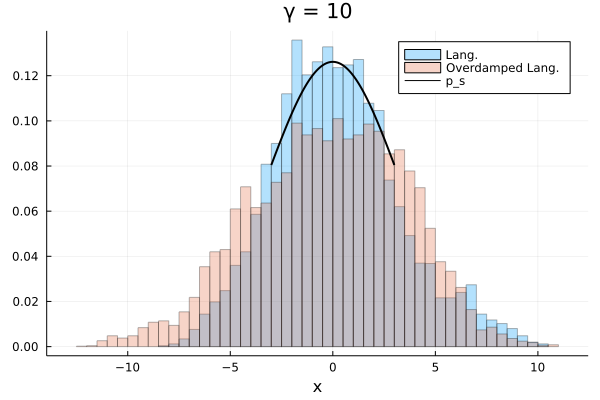

In [22]:
Tf = 1; Δt=0.1; D = 1;
M = 10000; # number of samples
γ = 10; # compare results as γ is varied
plt = compare_averages(Tf, Δt, γ, D; M = M)

# A note of caution: numerical errors in SDEs

The Euler-Maruyama can go unstable (just like the Euler scheme for ODEs!), although unstabilities may be more easily missed!

Let's consider the example below, as we vary $\Delta t$. The scheme is stable for $\gamma\Delta t < 1$. 

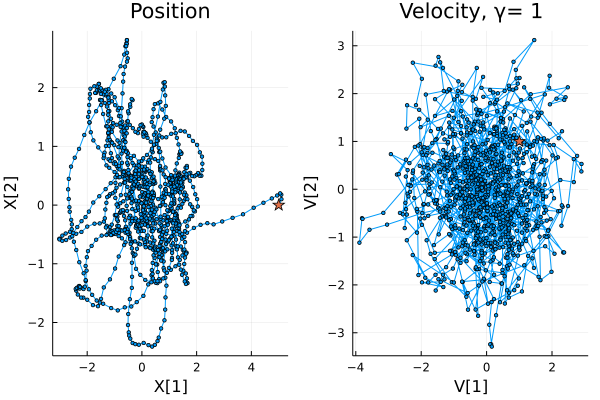

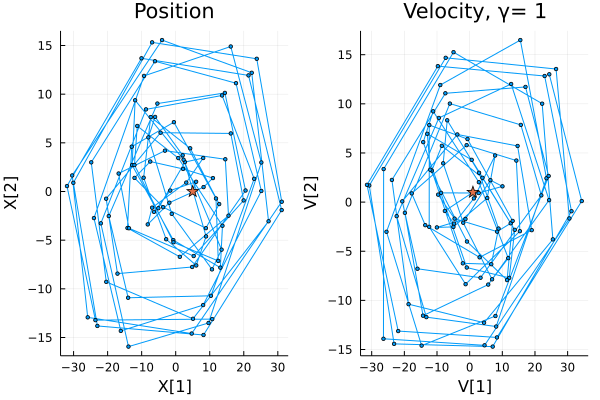

In [23]:
## Problem parameters
γ = 1; # drag coefficient       ## change to γ = 10, 100 for more damping
D = 1; # diffusion
Tf = 100;

Δt = 0.01;
plt = Langevin_trajectory(Tf, Δt, γ, D);
display(plt)

Δt = 0.1;
plt = Langevin_trajectory(Tf, Δt, γ, D);
display(plt)

Δt = 1; 
plt = Langevin_trajectory(Tf, Δt, γ, D);
display(plt)